## 0. Install and Import Dependencies

In [ ]:
# !pip install easyocr==1.4.1
# !pip install imutils
# !pip install os
# !pip install pathlib
# !pip install time
# !pip install opencv-python

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import pathlib
import os
import time

In [ ]:
#以time.ctime()去得出存有當前時間的list
#並以當前時間命名mp4檔，並回傳。
# image name = a1 + a2 + "_" + a3 + a4 + ".mp4"
def name_txt_by_current_time():
    #---------use current time to name img----------------------------------------------------------
    A = time.ctime()
    A = A.split()
    #print("value of time.ctime(): {}".format(A))
    #['Mon', 'Oct', '25', '07:16:50', '2021']

    #image name = a1 + a2 + "_" + a3 + a4
    a1='0'
    mon = {'Oct':'10', 'Nov':'11' , 'Dec':'12', 'Jan':'01' , 'Feb':'02', 'Mar':'03' , 'Apr':'04', 'May':'05' , 'Jan':'06', 'Jul':'07' , 'Aug':'08', 'Sep':'09'}

    for (key, value) in mon.items():
        if A[1]==key:
            a1=value
            #print("a1 = {}".format(a1))

    a2 = A[2]

    TMP = A[3]
    a3 = TMP[0:2]
    a4 = TMP[3:5]

    img_name = a1 + a2 + "_" + a3 + a4 + ".txt"
    #print("img_name: {}".format(img_name))
    return img_name

def clear_file(file_PATH):
    with open(file_PATH, 'r+',encoding="utf-8") as f1:
        f1.truncate(0)
    # 關閉檔案
    f1.close()
    return None 

#reset為1則清除檔案內容在輸入其他資料夾檔案
def write_many_line_to_a_file(file_PATH, list_of_text_to_append, reset):
    if reset==1:
        clear_file(file_PATH)

    with open(file_PATH, "w+",encoding="utf-8") as f1:
        print('writing file now............')
        f1.seek(0)

        for line in list_of_text_to_append:
            f1.write(line)
    # 關閉檔案
    f1.close()
    return None 

## 1. Read in Image, Grayscale and Blur

Start Processing...



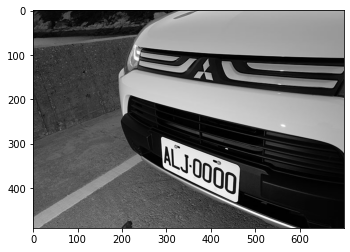

In [ ]:
# 1. Read in Image, Grayscale and Blur
actual_answer = 'ALJ0000'#修改成正確的車牌號碼
img = cv2.imread("image6.jpg")#修改成要測試的圖片
print('Start Processing...\n')
start_time = time.time()  #紀錄起始時間
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

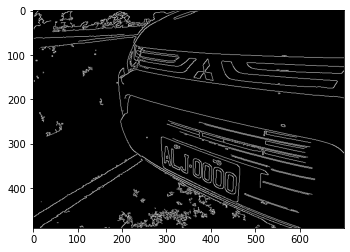

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [ ]:
print(location)

[[[288 286]]

 [[295 355]]

 [[461 429]]

 [[459 347]]]


In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

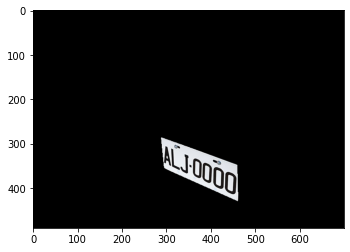

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

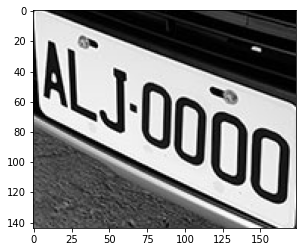

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
print(result)
print(result[0][-2])  #辨識出的車牌號碼
print("Are recognition-answer and actual-answer equal?\n{}".format(result[0][-2] == actual_answer))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[11.358776550108812, -8.977128298476615], [200.93894929177785, 80.95348886340162], [166.64122344989119, 148.9771282984766], [-21.93894929177784, 59.04651113659838]], 'Ajoooo', 0.13515803456245543)]
Ajoooo
Are recognition-answer and actual-answer equal?
False


In [ ]:
# 4.2 write result to .txt
parent_path = str(pathlib.Path().absolute())
file_name_2 = "/" + name_txt_by_current_time()
file_path2 = parent_path + file_name_2
write_many_line_to_a_file(file_path2, str(result[0][-2]), 0)#把車牌號碼寫入TXT

writing file now............


## 5. Render Result

Time cost: 4.8346710205078125 s


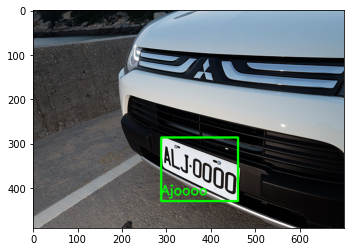

In [ ]:
#5. Render Result
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
end_time = time.time()
print('Time cost: {} s'.format(end_time - start_time)) #計算經過時間總長